# Objectives

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has provided the data containing images of unique plants belonging to 12 different species. You being a data scientist, need to build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

# Data Description

This dataset contains images of unique plants belonging to 12 different species.
The data file names are:
1. images.npy
2. Label.csv

Due to the large volume of data, the images were converted to numpy arrays and stored in images.npy file and the corresponding labels are also put into Labels.csv so that you can work on the data/project seamlessly without having to worry about the high data volume.
The goal of the project is to create a classifier capable of determining a plant's species from an image.


## Plant species


1. Black-grass
2. Charlock
3. Cleavers
4. Common Chickweed
5. Common Wheat
6. Fat Hen
7. Loose Silky-bent
8. Maize
9. Scentless Mayweed
10. Shepherds Purse
11. Small-flowered Cranesbill
12. Sugar beet

In [ ]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.0 Import necessary libraries

In [ ]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Reading Dataset

In [ ]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/cnn/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/cnn/Labels.csv')

#  Shape of the dataset

In [ ]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


## Plotting using matplotlib and OpenCV

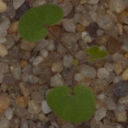

In [ ]:
cv2_imshow(images[6])

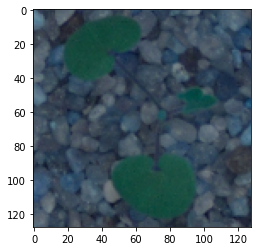

In [ ]:
plt.imshow(images[6])


- The images are being shown in different color.
- matplotlib images is shown in RGB.




In [ ]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [ ]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

## Image plot 

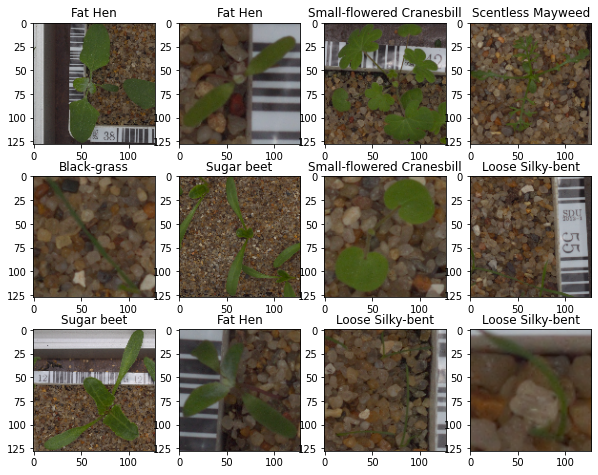

In [ ]:
plot_images(images,labels)

## Checking for data imbalance


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

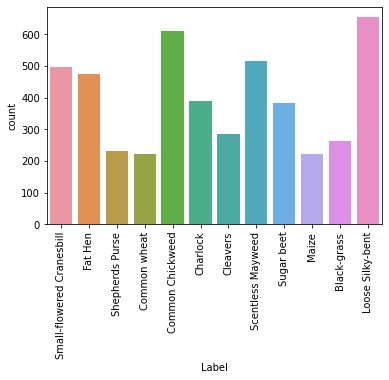

In [ ]:
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical')

## Observations-  Insights based on EDA

1. As you can see from the above plot, the dataset is not balanced.
2. There are 12 different categories of plants.
3. The Loose **Silky** bent category has the highest number of plant seedlings followed by Common **Chickweed**

## Data Pre-Processing

1. Resizing

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

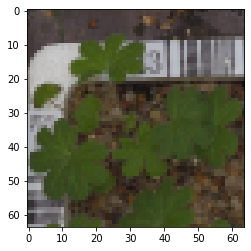

In [ ]:
# Before removal of blurring
plt.imshow(images_decreased[3])

## Visualizing images using Gaussian Blur - (removal of unwanted noise) 

In [ ]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))

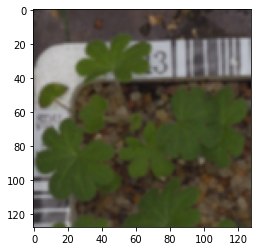

In [ ]:
# After denoising
plt.imshow(images_gb[3])

# Splitting the dataset into train and test

1. I be using 10% of my data for testing and 90% for training.
2. I will be using the train_test_split() function from scikit-learn. Here, i split the dataset while keeping the test size constant at 0.1. This means that 10% of total data is used for testing, while 90% is used for training.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(4275, 64, 64, 3) (4275, 1)
(475, 64, 64, 3) (475, 1)


# Make data compatible

1. - Convert labels from digits to one hot vector

In [ ]:
# Convert labels from names to one hot vectors using Labelbinarizer. 

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_test_encoded=enc.transform(y_test)

# Checking the shape of the data.

In [ ]:
y_train_encoded.shape

(4275, 12)

In [ ]:
y_test_encoded.shape

(475, 12)

## Data Normalization
Since the image pixel values range from 0-255, I will scale the data by using a method called normalization. we shall divide all the pixel values by 255 to standardize the images to have values between 0-1.

In [ ]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

# Model Building - Convolutional Neural Network (CNN)- Use different layers in the model

Let's create a CNN model sequentially.

1. First, we need to clear the previous model's history from the session.

2. In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.


In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Now, let's build a CNN Model with the following 2 main parts -

1. The Feature Extraction layers which are comprised of convolutional and pooling layers.
2. The Fully Connected classification layers for prediction.


In [ ]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

# Fitting the model on the train data

In [ ]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_split=0.1,
            # shuffle=True,
            batch_size=32,
            verbose=2
)


Epoch 1/30
121/121 - 13s - loss: 2.3939 - accuracy: 0.1580 - val_loss: 2.1136 - val_accuracy: 0.3131 - 13s/epoch - 109ms/step
Epoch 2/30
121/121 - 2s - loss: 2.0894 - accuracy: 0.2896 - val_loss: 1.8327 - val_accuracy: 0.4112 - 2s/epoch - 12ms/step
Epoch 3/30
121/121 - 2s - loss: 1.9356 - accuracy: 0.3130 - val_loss: 1.7256 - val_accuracy: 0.4136 - 2s/epoch - 12ms/step
Epoch 4/30
121/121 - 2s - loss: 1.8149 - accuracy: 0.3540 - val_loss: 1.6150 - val_accuracy: 0.4743 - 2s/epoch - 12ms/step
Epoch 5/30
121/121 - 2s - loss: 1.7812 - accuracy: 0.3647 - val_loss: 1.6099 - val_accuracy: 0.4720 - 2s/epoch - 16ms/step
Epoch 6/30
121/121 - 2s - loss: 1.7215 - accuracy: 0.3681 - val_loss: 1.4958 - val_accuracy: 0.5164 - 2s/epoch - 14ms/step
Epoch 7/30
121/121 - 1s - loss: 1.6932 - accuracy: 0.3839 - val_loss: 1.4627 - val_accuracy: 0.5187 - 1s/epoch - 12ms/step
Epoch 8/30
121/121 - 2s - loss: 1.6568 - accuracy: 0.4037 - val_loss: 1.3966 - val_accuracy: 0.5257 - 2s/epoch - 12ms/step
Epoch 9/30
12

# Model Evaluation

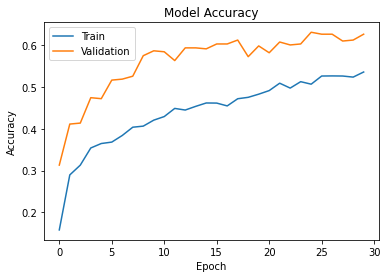

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Observations:

1. The above plot shows that the training accuracy of the model was bad.
2. The validation accuracy was also bad.
3. The model seems to overfit on the data.

# Evaluating the model on test data

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.2470 - accuracy: 0.5979 - 164ms/epoch - 11ms/step


# Generating the predictions using test data

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

In [ ]:
y_pred

array([[2.1932204e-08, 4.7352591e-14, 1.8432630e-11, ..., 6.5752235e-03,
        1.0544432e-10, 9.5612428e-05],
       [6.9429601e-11, 4.2921055e-02, 2.8177490e-02, ..., 7.6901145e-02,
        7.9386830e-01, 1.2539020e-02],
       [3.4196020e-07, 5.2952398e-02, 4.4496585e-02, ..., 8.1597090e-02,
        6.5562540e-01, 3.7919909e-02],
       ...,
       [2.9003823e-01, 1.7288968e-09, 2.6040418e-05, ..., 3.6838199e-11,
        3.6360033e-11, 3.9363777e-06],
       [2.1111182e-06, 7.3803179e-03, 1.4100176e-01, ..., 5.1324282e-02,
        1.2664284e-03, 2.8731057e-02],
       [2.2431825e-06, 6.7102224e-02, 5.7333931e-02, ..., 8.7633818e-02,
        5.8748698e-01, 5.0406229e-02]], dtype=float32)

## Plotting the Confusion Matrix

The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.

The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.

We will use the argmax() function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.

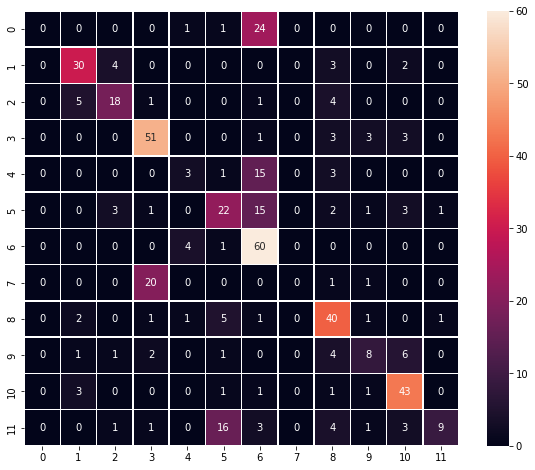

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Observations

1. Some of the classes are not predicted correctly.
2. In comparison to the rest, we can see that classes 3,6,8, and 10 are well classified.
3. We can also observe that other classes are mostly misclassified.

# Methods for improving model performance

1. The initial model appears to overfit. 
2. This problem can be solved with data augmentation and Batch Normalization.


In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20, 
                              fill_mode='nearest'
                              )
# test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                        

In [ ]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history = model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_test_normalized,y_test_encoded),
                    verbose=1)

Epoch 1/25
66/66 [==============================] - 7s 94ms/step - loss: 2.2191 - accuracy: 0.1995 - val_loss: 2.3736 - val_accuracy: 0.2526
Epoch 2/25
66/66 [==============================] - 6s 85ms/step - loss: 1.6964 - accuracy: 0.3975 - val_loss: 2.2456 - val_accuracy: 0.2737
Epoch 3/25
66/66 [==============================] - 6s 84ms/step - loss: 1.5004 - accuracy: 0.4666 - val_loss: 2.1298 - val_accuracy: 0.3095
Epoch 4/25
66/66 [==============================] - 6s 84ms/step - loss: 1.3841 - accuracy: 0.5063 - val_loss: 1.9664 - val_accuracy: 0.4737
Epoch 5/25
66/66 [==============================] - 6s 85ms/step - loss: 1.3305 - accuracy: 0.5262 - val_loss: 1.9190 - val_accuracy: 0.4379
Epoch 6/25
66/66 [==============================] - 6s 85ms/step - loss: 1.2532 - accuracy: 0.5538 - val_loss: 1.4822 - val_accuracy: 0.5600
Epoch 7/25
66/66 [==============================] - 6s 86ms/step - loss: 1.2027 - accuracy: 0.5654 - val_loss: 1.3758 - val_accuracy: 0.5684
Epoch 8/25
66

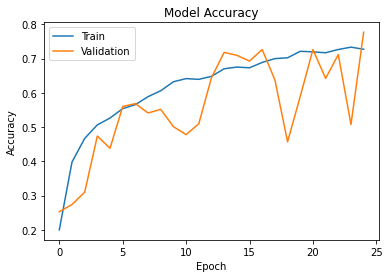

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.7626 - accuracy: 0.7768 - 120ms/epoch - 8ms/step


## Observation:
We can observe that our accuracy has improved compared to our previous model.

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

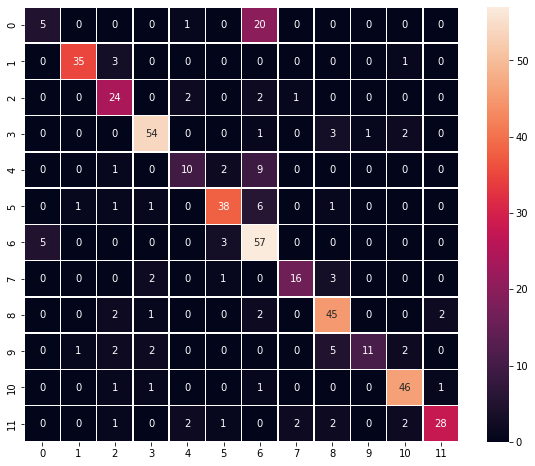

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Observation:

1. The confusion matrix appears to be improving as well, however there is still some confusion with the 2,4,7,9,11,5,7 classes of monkey species.
2. The 5th class is the most confused class among all.


# Transfer Learning using VGG16
1. I will try to build another model by using the idea of Transfer Learning. I will be loading a pre-built architecture - VGG16, which was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014.

For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.

In [ ]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(16, activation='relu'))
new_model.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                65568     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 12)                204       
                                                                 
Total params: 14,780,988
Trainable params: 66,300
Non-

In [ ]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history_vgg16 = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_test_normalized,y_test_encoded),
                    verbose=1)

Epoch 1/25
66/66 [==============================] - 11s 141ms/step - loss: 2.3553 - accuracy: 0.1893 - val_loss: 2.1940 - val_accuracy: 0.2695
Epoch 2/25
66/66 [==============================] - 7s 110ms/step - loss: 2.1410 - accuracy: 0.2700 - val_loss: 2.0062 - val_accuracy: 0.3621
Epoch 3/25
66/66 [==============================] - 7s 109ms/step - loss: 1.9605 - accuracy: 0.3303 - val_loss: 1.8093 - val_accuracy: 0.4147
Epoch 4/25
66/66 [==============================] - 7s 108ms/step - loss: 1.8005 - accuracy: 0.3797 - val_loss: 1.6936 - val_accuracy: 0.4568
Epoch 5/25
66/66 [==============================] - 7s 105ms/step - loss: 1.6785 - accuracy: 0.4203 - val_loss: 1.6024 - val_accuracy: 0.4589
Epoch 6/25
66/66 [==============================] - 7s 108ms/step - loss: 1.5938 - accuracy: 0.4521 - val_loss: 1.5457 - val_accuracy: 0.4884
Epoch 7/25
66/66 [==============================] - 7s 104ms/step - loss: 1.5158 - accuracy: 0.4681 - val_loss: 1.4937 - val_accuracy: 0.4947
Epoch

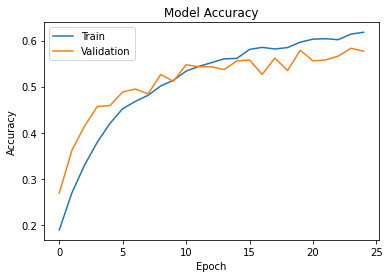

In [ ]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 1.1589 - accuracy: 0.5768 - 506ms/epoch - 34ms/step


In [ ]:
# Here we would get the output as probablities for each category
y_pred=new_model.predict(X_test_normalized)

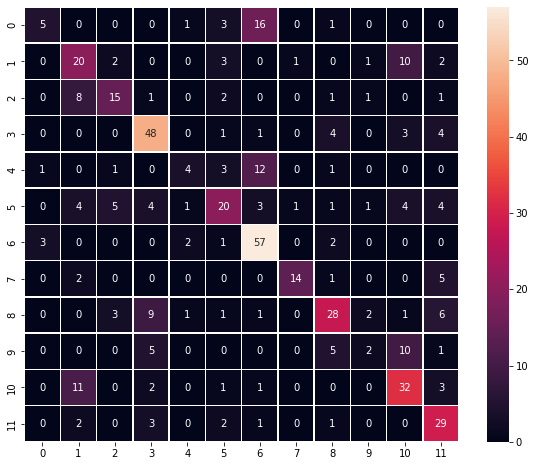

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

1. The accuracy curve shows that VGG16 model does not outperform Augmented-Model. This could be due to the data we're using. There's a chance that these images aren't in the ImageNet dataset, whose weights have been used to build our CNN model.

2. The Augmented model is our best model and we can use this model to predict and visualize some test images.

# Visualizing the prediction:

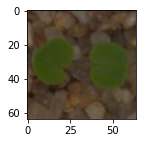

Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


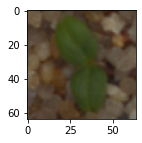

Predicted Label ['Cleavers']
True Label Cleavers


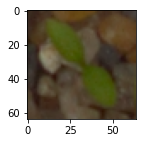

Predicted Label ['Common Chickweed']
True Label Common Chickweed


<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))

# Conclusion

1. We can observe from the accuracy curve of all the models that my augmented model was the best model. 

2. The augmented model predicted the majority of the classes better than the other models with a test accuracy of about is 66.7%.

3. VGGnet did not outperform my augmented model. 

In [ ]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation','Transfer Learning Model'],'Train Accuracy':['46.5%','72.67%','61.79%'],'Test Accuracy':['59.79%','66.74%','57.68%']})

,Models,Train Accuracy,Test Accuracy
0,Base CNN Model,46.5%,59.79%
1,CNN Model with Data Augmentation,72.67%,66.74%
2,Transfer Learning Model,61.79%,57.68%


# Scope of Improvement

1. These models can be further improved by training with different filter sizes and different number of filters.

2. These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64.
3. Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.
4. Other Transfer Learning architectures can also be used to train the CNN model and these models can be used for classification.
